# Stochastic Volatility Models

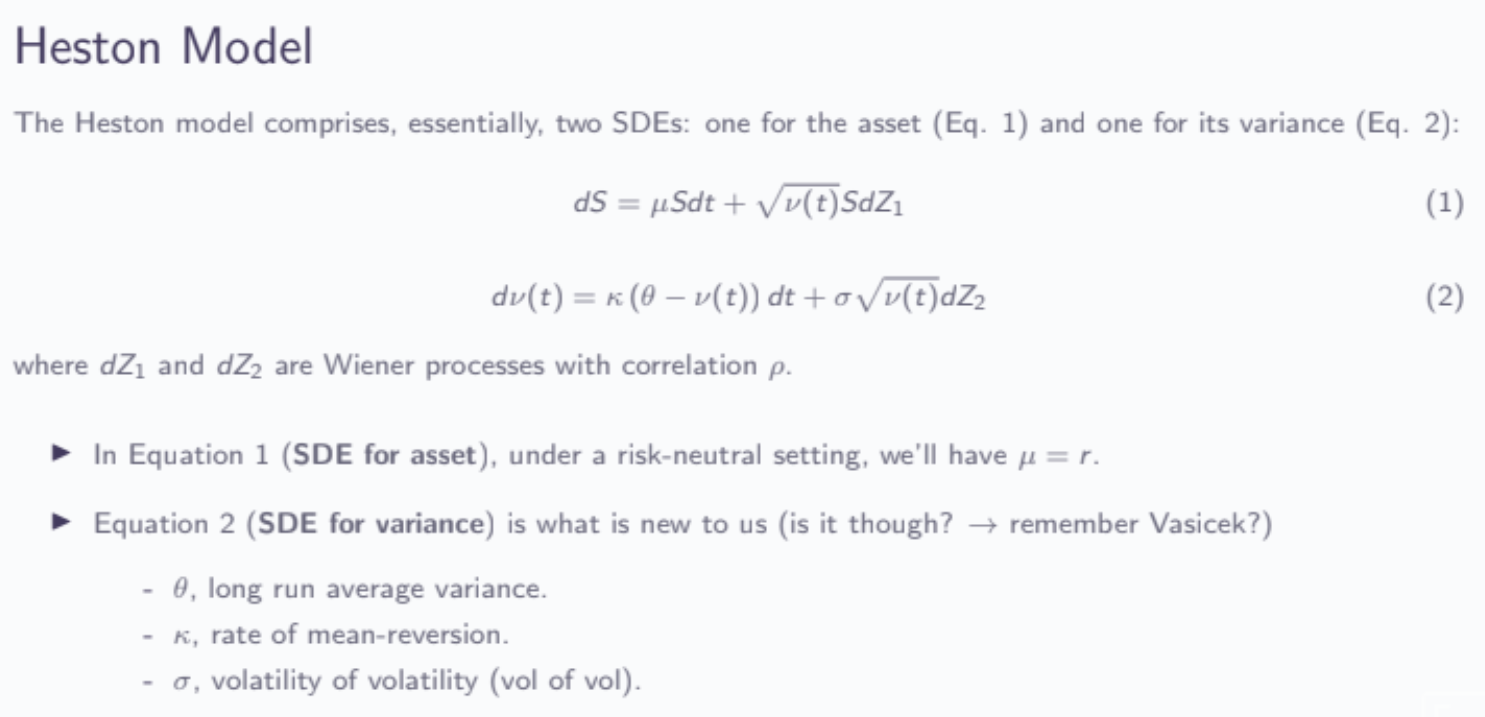

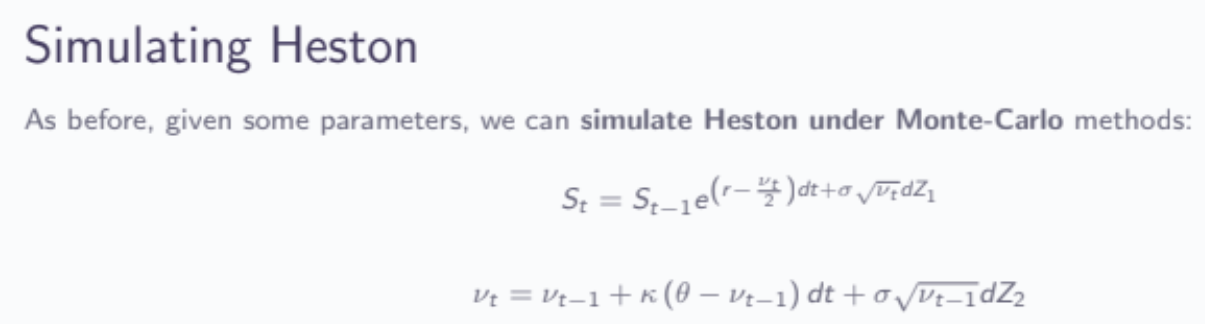

$$
\Large\begin{equation*} 
    S_t = S_{t-1} e^{\left( r - \frac{\nu_t}{2} \right) dt + \sigma \sqrt{\nu_t} dZ_1}
\end{equation*} 
$$
$$
\Large\begin{equation*} 
    \nu_t = \nu_{t-1} + \kappa \left( \theta - \nu_{t-1} \right) dt + \sigma \sqrt{\nu_{t-1}}dZ_2
\end{equation*}
$$

where,

$\theta:$ long-term average variance

$\kappa:$ rate of mean-reversion of the variance

$\sigma:$ volatility of the variance process

# My Try

In [213]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

def gen_dZ(rho, n):
    """Generates correlated standard brownian motions dZ1 and dZ2

    Args:
        rho (float): correlation between the "asset brownian motion" dZ1
                    and the "variance brownian motion" dZ2
        n (int): number of timesteps
    """
    dZ1 = np.random.standard_normal(n)  # create the first brownian motion elements, for asset price process
    temp_arr = np.random.standard_normal(n)  # draw independent standard gaussians to use for correlated random variables
    dZ2 = rho * dZ1 + np.sqrt(1 - rho**2) * temp_arr  # create the second brownian motion elements, for variance process
    return dZ1, dZ2

def v(v0, kappa, theta, sigma, n, T, dZ2):
    """Calculates the variance process

    Args:
        v0 (float): initial variance value to start from
        kappa (float): parameter for the speed of mean-reversion
        theta (float): long term average of the variance
        dt (float): length of timestep
        sigma (float): volatility of the variance process
        rho (float): correlation between the "asset brownian motion" dZ1
                    and the "variance brownian motion" dZ2
        n (int): number of timesteps to simulate
        T (float): Time at the end of the process to be simulated (maturity date)
        dZ2 (np.array): Standard brownian motion interval values
        which are correlated to dZ1 with rho
    """
    dt = T/n
    v_arr = np.zeros(n)
    v_arr[0] = v0
    # print("v_arr =", v_arr)
    for t in range(1, n):
        v_arr[t] = np.maximum(v_arr[t-1] + kappa * (theta - v_arr[t-1]) * dt + sigma * np.sqrt(v_arr[t-1]) * dZ2[t] * np.sqrt(dt), 0)
    
    return v_arr

def S(S0, r, sigma, v_arr, T, dZ1):
    """Calculates the asset price process

    Args:
        S0 (float): Initial asset price at start
        r (float): risk-free rate
        sigma (float): volatility of the variance process
        v_arr (np.array): variance process generated by function v()
        T (float): Time at the end of the process to be simulated (maturity date)
        dZ1 (np.array): Standard brownian motion interval values
    """
    n = len(v_arr)
    dt = T/n
    
    S_arr = np.zeros(n)
    S_arr[0] = S0
    for t in range(1, n):
        S_arr[t] = S_arr[t-1] * np.exp((r - v_arr[t]/2)*dt + np.sqrt(v_arr[t])*dZ1[t]*np.sqrt(dt))
        
    return S_arr

def MC(M, v0, kappa, theta, sigma, n, T, rho, r, S0=None):
    if S0 is None:
        v_MC = np.zeros((M, n))
        for m in range(M):
            dZ1, dZ2 = gen_dZ(rho, n)
            v_MC[m, :] = np.maximum(v(v0, kappa, theta, sigma, n, T, dZ2), 0)
        return v_MC
    else:
        v_MC = np.zeros((M, n))
        S_MC = np.zeros((M, n))
        for m in range(M):
            dZ1, dZ2 = gen_dZ(rho, n)
            v_arr = v(v0, kappa, theta, sigma, n, T, dZ2)
            v_MC[m, :] = np.maximum(v_arr, 0)
            S_MC[m, :] = S(S0, r, sigma, v_arr, T, dZ1)
    return v_MC, S_MC

S_MC =
 [[100.         100.317716   100.75350696 ...  87.04781968  90.96318785
   89.30491596]
 [100.          98.7946024   99.00063594 ...  85.9986973   88.90039625
   91.41771243]
 [100.          94.33225139  95.62030813 ...  76.91522046  76.45339295
   77.32245434]
 ...
 [100.          98.26982032  99.1116722  ...  81.89927436  85.41862552
   83.78623014]
 [100.         103.62347696 100.78514956 ... 102.04710979 101.1676577
  100.59003198]
 [100.          97.73227488  94.15910537 ...  87.60395506  86.02944305
   85.56474383]]


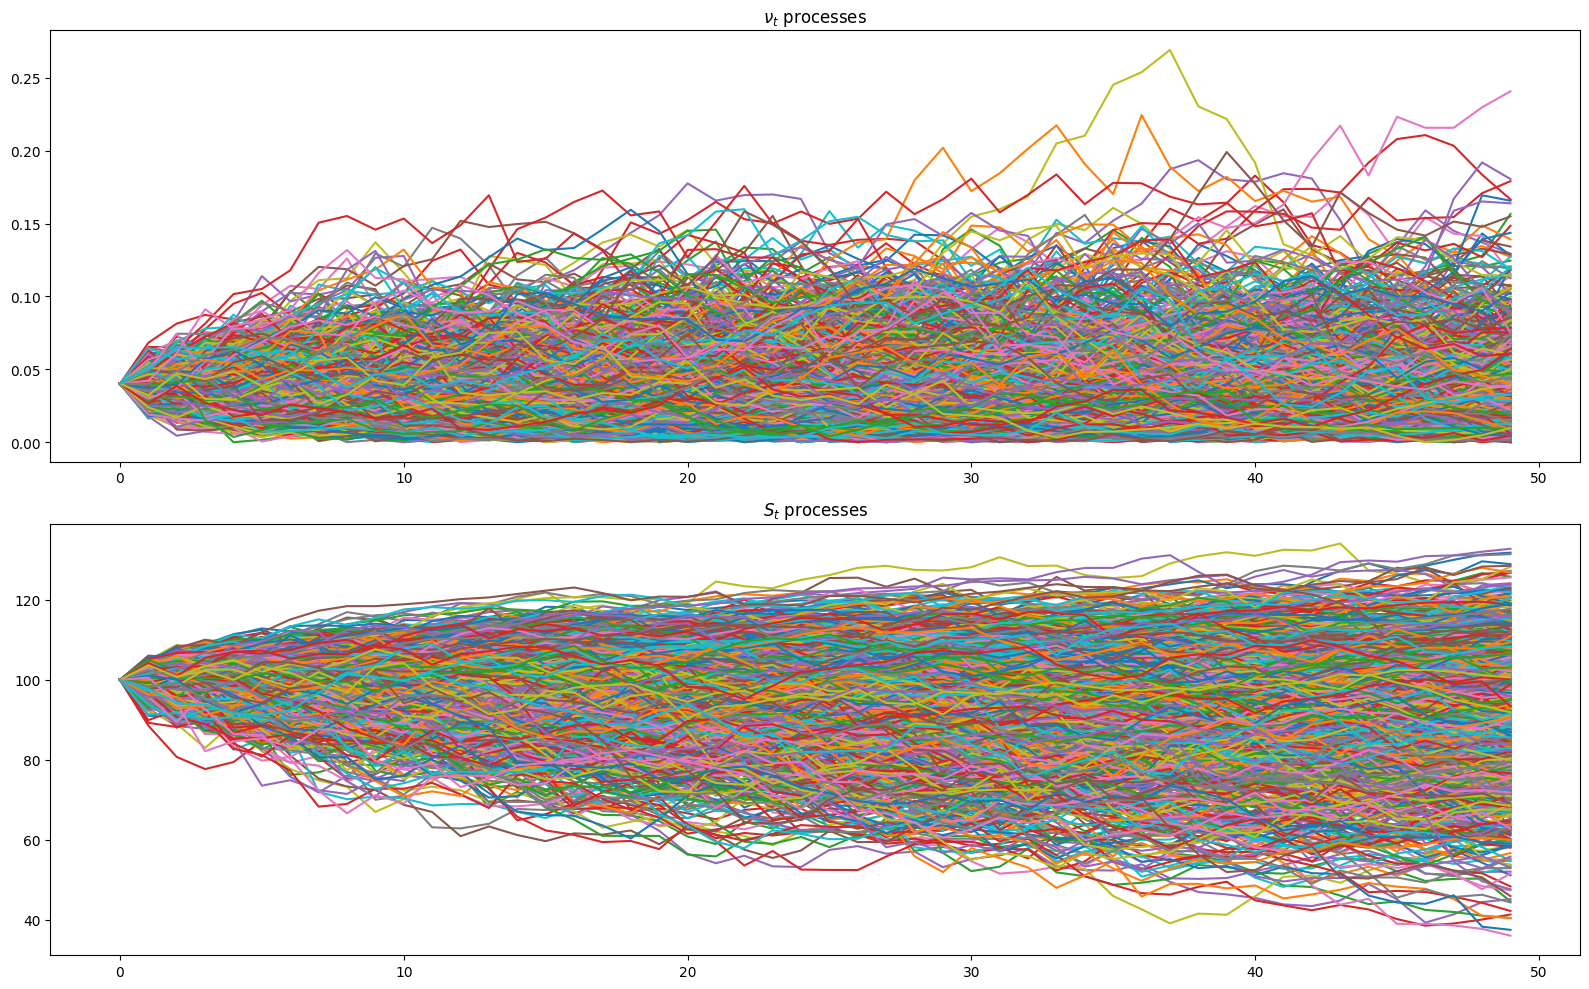

In [214]:
v0 = 0.04
kappa = 2
sigma = 0.3
theta = 0.04
rho = -0.9

S0 = 100  # Current underlying asset price
r = 0.05  # Risk-free rate
M0 = 50  # Number of time steps in a year
T = 1  # Number of years
n = int(M0 * T)  # Total time steps
M = 1000  # Number of simulations

# Simulate
v_MC, S_MC = MC(M, v0, kappa, theta, sigma, n, T, rho, r, S0)

print("S_MC =\n", S_MC)

fig, axs = plt.subplots(2, 1, figsize=(16, 10))
axs[0].plot(v_MC.T)
axs[0].set_title(r"$\nu_t$ processes")
axs[1].plot(S_MC.T)
axs[1].set_title("$S_t$ processes")
fig.tight_layout()

In [215]:
def heston_opt_price_MC(K, t, MC_params, call_or_put="C"):
    M, v0, kappa, theta, sigma, n, T, rho, r, S0 = MC_params
    v_MC, S_MC = MC(M, v0, kappa, theta, sigma, n, T, rho, r, S0)
    if call_or_put == "C":
        payoffs = np.maximum(0, S_MC[:, -1] - K)
    else:
        payoffs = np.maximum(0, K - S_MC[:, -1])
        
    return np.exp(-r * (T-t)) * payoffs.mean()

In [216]:
# MC params
v0 = 0.04
kappa = 2
sigma = 0.3
theta = 0.04
rho = -0.9
S0 = 100  # Current underlying asset price
r = 0.05  # Risk-free rate
M0 = 50  # Number of time steps in a year
T = 1  # Number of years
n = int(M0 * T)  # Total time steps
M = 1000  # Number of simulations

# Option params
K = 90
r = 0.05
t = 0

MC_params = [M, v0, kappa, theta, sigma, n, T, rho, r, S0]

call_price = heston_opt_price_MC(K, t, MC_params, "C")
print("call price =", call_price)

call price = 7.798177964907877


# WQU

In [217]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

def SDE_vol(v0, kappa, theta, sigma, T, M, Ite, rand, row, cho_matrix):
    dt = T / M  # T = maturity, M = number of time steps
    v = np.zeros((M + 1, Ite), dtype=np.float)
    v[0] = v0
    sdt = np.sqrt(dt)  # Sqrt of dt
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        v[t] = np.maximum(
            0,
            v[t - 1]
            + kappa * (theta - v[t - 1]) * dt
            + np.sqrt(v[t - 1]) * sigma * ran[row] * sdt,
        )
    return v

def Heston_paths(S0, r, v, row, cho_matrix):
    S = np.zeros((M + 1, Ite), dtype=float)
    S[0] = S0
    sdt = np.sqrt(dt)
    for t in range(1, M + 1, 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[row] * sdt)

    return S

def random_number_gen(M, Ite):
    rand = np.random.standard_normal((2, M + 1, Ite))
    return rand

v0 = 0.04
kappa_v = 2
sigma_v = 0.3
theta_v = 0.04
rho = -0.9

S0 = 100  # Current underlying asset price
r = 0.05  # Risk-free rate
M0 = 50  # Number of time steps in a year
T = 1  # Number of years
M = int(M0 * T)  # Total time steps
Ite = 10000  # Number of simulations
dt = T / M  # Length of time step

In [218]:
# Generating random numbers from standard normal
rand = random_number_gen(M, Ite)


# Covariance Matrix
covariance_matrix = np.zeros((2, 2), dtype=np.float64)
covariance_matrix[0] = [1.0, rho]
covariance_matrix[1] = [rho, 1.0]
cho_matrix = np.linalg.cholesky(covariance_matrix)
cho_matrix

array([[ 1.        ,  0.        ],
       [-0.9       ,  0.43588989]])

In [219]:
# Volatility process paths
V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, Ite, rand, 1, cho_matrix)

# Underlying price process paths
S = Heston_paths(S0, r, V, 0, cho_matrix)

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

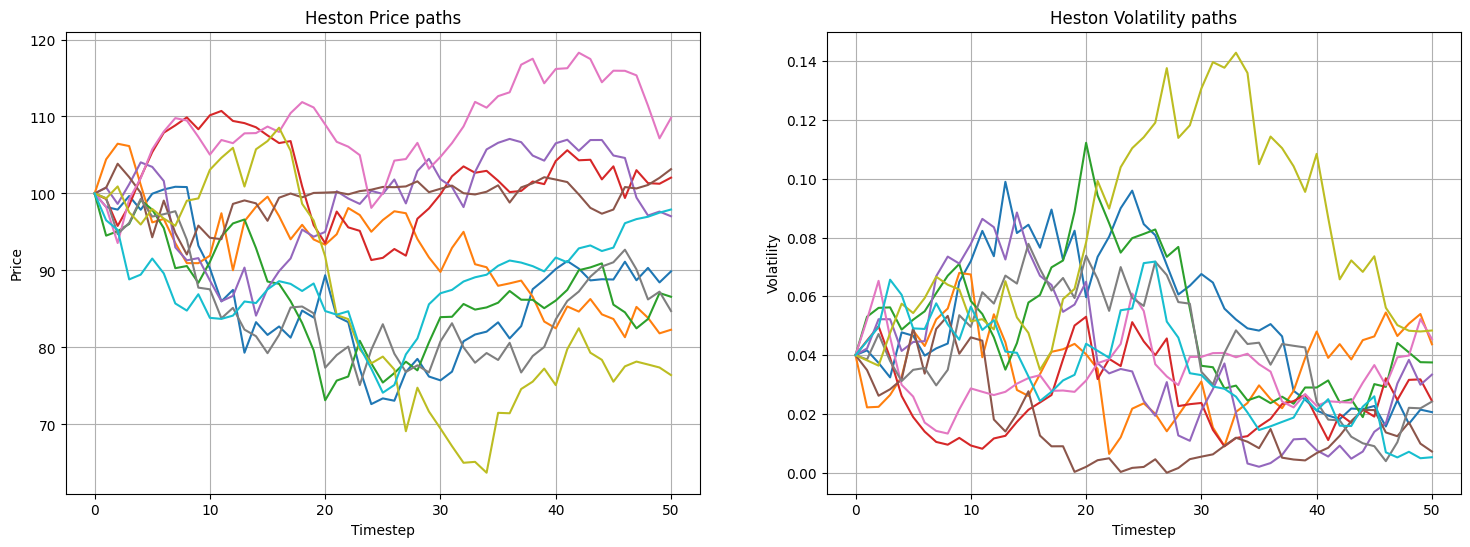

In [ ]:
def plot_paths(n):
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(range(len(S)), S[:, :n])
    ax1.grid()
    ax1.set_title("Heston Price paths")
    ax1.set_ylabel("Price")
    ax1.set_xlabel("Timestep")

    ax2.plot(range(len(V)), V[:, :n])
    ax2.grid()
    ax2.set_title("Heston Volatility paths")
    ax2.set_ylabel("Volatility")
    ax2.set_xlabel("Timestep")


plot_paths(10)